# Compare exponential and polynomial fit. Needs tidy up!

We use data from the files at https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

Thank you @CSSEGISandData for providing the data!

In [227]:
%config InlineBackend.figure_formats = ['svg']
import math
from numpy import log, exp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
figsize = (8, 6)   # need bigger size otherwise xlabels are cut-off in svg files

import os
import pandas as pd
import seaborn as sb
sb.set_style('darkgrid')
import scipy
import numpy as np
import iminuit

base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

def string_to_date(input_):
    """Converts string of type 01/22/02 [for 22 Jan 2020] into datetime object"""
    # return pd.to_datetime(input_, format='%m/%d/%y', errors='ignore')
    return pd.to_datetime(input_, format='%m/%d/%y')

def set_date_formatting(ax):
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))
    ax.tick_params(axis='x', rotation=90)

# read data from web
#

def fetch_data(names = ['confirmed', 'deaths']):
    """Return 3 data frames:
    [confirmed, deaths], location_info
    
    where confirmed, deaths and recovered are data frames with countries/regions in the rows, and 
    days in the columns
    
    and location_info provides additional information about the locations.
    
    We assume all three tables have the same entries"""
    location_info = pd.DataFrame()
    dfs = []
    for name in names:
        url = os.path.join(base_url, "time_series_covid19_" + name + "_global.csv")
        df = pd.read_csv(url, index_col=1)
    
        if not name == 'Recovered':
            location_info['Lat'] = df['Lat']
            location_info['Long'] = df['Long']
            location_info['Province/State'] = df['Province/State']
            location_info['location'] = df.index + "-" + df['Province/State']
        else:
            pass  # no location info in recovered since 14 March
        ## df = df.drop(labels=["Lat", "Long", "Province/State"], axis=1)
        df = df.drop(labels=["Lat", "Long"], axis=1)
        
        # extract dates from strings
        dates = string_to_date(df.columns[1:])        
        # use those objects as new column labels
        df.columns = [df.columns[0]] + list(dates)
        print(f"{name:10}: last data point from {max(dates[1:])}")
        # dfs.append([df, location_info)
        dfs.append(df)

    return dfs


confirmed, deaths = fetch_data()

# show counries with mosth deaths
deaths.sort_values(by=deaths.columns[-1], ascending=False).iloc[0:10,-8:]

confirmed : last data point from 2020-03-24 00:00:00
deaths    : last data point from 2020-03-24 00:00:00


,2020-03-17 00:00:00,2020-03-18 00:00:00,2020-03-19 00:00:00,2020-03-20 00:00:00,2020-03-21 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00
Country/Region,,,,,,,,
Italy,2503,2978,3405,4032,4825,5476,6077,6820
China,3111,3122,3130,3133,3139,3153,3153,3160
Spain,533,623,830,1043,1375,1772,2311,2808
Iran,988,1135,1284,1433,1556,1685,1812,1934
France,148,148,243,450,562,674,860,1100
US,108,118,200,244,307,417,557,706
United Kingdom,55,71,137,177,233,281,335,422
Netherlands,43,58,76,106,136,179,213,276
Germany,24,28,44,67,84,94,123,157


In [228]:
deaths.sort_values(by=deaths.columns[-1], ascending=False).iloc[:,-8:]


,2020-03-17 00:00:00,2020-03-18 00:00:00,2020-03-19 00:00:00,2020-03-20 00:00:00,2020-03-21 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00
Country/Region,,,,,,,,
Italy,2503,2978,3405,4032,4825,5476,6077,6820
China,3111,3122,3130,3133,3139,3153,3153,3160
Spain,533,623,830,1043,1375,1772,2311,2808
Iran,988,1135,1284,1433,1556,1685,1812,1934
France,148,148,243,450,562,674,860,1100
...,...,...,...,...,...,...,...,...
China,0,0,0,0,0,0,0,0
Madagascar,0,0,0,0,0,0,0,0
China,0,0,0,0,0,0,0,0


In [229]:
def double_time_exponential(t1, t2, q1, q2):
    return (t2 - t1) * (log(2) / log(q2/q1) )

def growth_rate(double_time):
    return log(2)/double_time


# t1, t2, q1, q2 = 0, 1, 1, 2
# double_time_exponential(t1, t2, q1, q2), growth_rate(double_time_exponential(t1, t2, q1, q2) )

def double_time_exponential(q2_div_q1, t2_minus_t1=None):
    if t2_minus_t1 is None:
        t2_minus_t1 = np.ones(q2_div_q1.shape)
    return (t2_minus_t1) * (log(2) / log(q2_div_q1) )





def stack_country(country = "Germany"):

    #create one DataFrame for country/region
    c_df = pd.DataFrame()
    if country == "United Kingdom":
        # UK has three Provinces: Channel Islands, Gibraltar and UK. Only need last one
        c_df['confirmed'] = confirmed.loc[country].drop('Province/State', axis=1).iloc[2]
        c_df['deaths'] = deaths.loc[country].drop('Province/State', axis=1).iloc[2]
    elif country == "China": 
        # Use only Hubei province
        tmp = confirmed.loc[country]
        c_df['confirmed'] = tmp[tmp['Province/State'] == "Hubei"].T['China']
        tmp = deaths.loc[country]
        c_df['deaths'] = tmp[tmp['Province/State'] == "Hubei"].T['China']
        c_df.drop("Province/State", inplace=True)
    elif country in ['US', 'France']:
        c_df['confirmed'] = confirmed.loc[country].sum()
        c_df['deaths'] = deaths.loc[country].sum()
        c_df.drop('Province/State', inplace=True)
    else:
        c_df['confirmed'] = confirmed.loc[country].drop('Province/State')
        c_df['deaths'] = deaths.loc[country].drop('Province/State')

  
    c_df.index = string_to_date(c_df.index)
    c_df.country = country  # remember which country we work on, just in case
    
    c_df['days-td'] = c_df.index - c_df.index.min()  # days as TimeDelta type
    c_df['days'] = c_df['days-td'].astype("timedelta64[D]").astype(float)
    
    c_df['new_confirmed'] = c_df['confirmed'].diff()
    c_df['new_deaths'] = c_df['deaths'].diff()
    
    c_df['confirmed_pct'] = c_df['confirmed'].pct_change()+1
    c_df['deaths_pct'] = c_df['deaths'].pct_change()+1
    
    # growth rate
    c_df['deaths_double_time'] = double_time_exponential(c_df['deaths_pct'])
    c_df['confirmed_double_time'] = double_time_exponential(c_df['confirmed_pct'])
    c_df['deaths_growth_rate'] = growth_rate(c_df['deaths_double_time'])
    c_df['confirmed_growth_rate'] = growth_rate(c_df['confirmed_double_time'])

    return c_df

In [230]:

c = stack_country("Germany")
c.tail(n=5)
c2 = stack_country("United Kingdom")
#c.tail(n=5)
#c2 = stack_country("Spain")
#c.tail(n=5)
#c2 = stack_country("Italy")
#c2.tail(n=5)
#c2 = stack_country("France")
#c2.tail(n=5)
#c2 = stack_country("China")
#c2 = stack_country("US")

                  

In [231]:
def overview_plot(c_df):
    fig, axes = plt.subplots(3, 1, figsize=(8, 14))
    ax = axes[0]
    set_date_formatting(ax)
    ax.plot(c_df.index, c_df['confirmed'], 'o-b', label='confirmed')
    ax.plot(c_df.index, c_df['deaths'], 'o-r', label='deaths')
    ax.legend(loc='center left')
    country = c_df.country
    ax.set_title(country + " accumulated data")
    ax.set_yscale('log')
    
    ax = axes[1]
    set_date_formatting(ax)
    ax.plot(c_df.index, c_df['deaths_double_time'], 'xr', label='double time deaths')
    ax.plot(c_df.index, c_df['confirmed_double_time'], 'ob', label='double time confirmed')
    ax.legend(loc='center left')
    ax.set_ylabel('days to double numbers \n bigger is better')
    maxy = min(10, max(c_df['confirmed_double_time']))
    ax.set_ylim(0, maxy)

    ax = axes[2]
    set_date_formatting(ax)
    ax.plot(c_df.index, c_df['deaths_growth_rate'], 'xr', label='growth rate deaths')
    ax.plot(c_df.index, c_df['confirmed_growth_rate'], 'ob', label='confirmed growth rate')
    ax.legend(loc='center left')
    ax.set_ylim(0, 0.5)
    ax.set_ylabel('growth rate r in\n f(t) = exp(r*t)\n(smaller is better)')
    
    # fig.savefig(f"figures/{country}-overview.svg")
    return axes

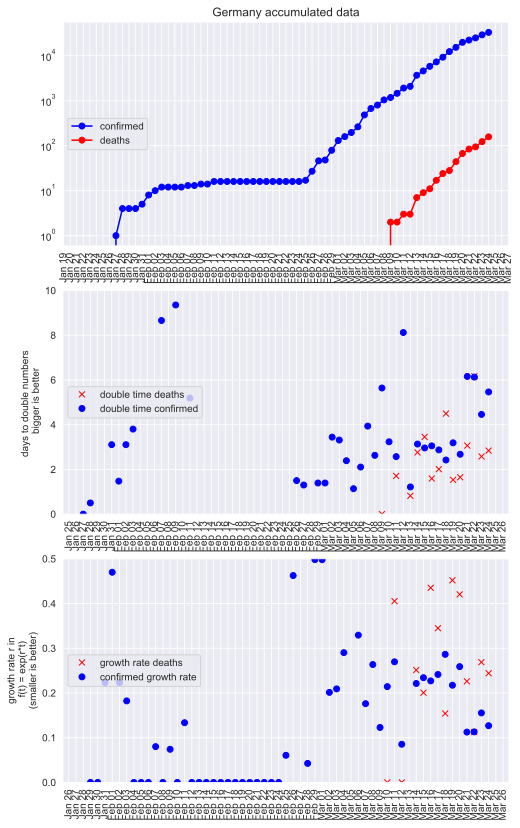

In [232]:
overview_plot(c);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1cb37ad0>,
      dtype=object)

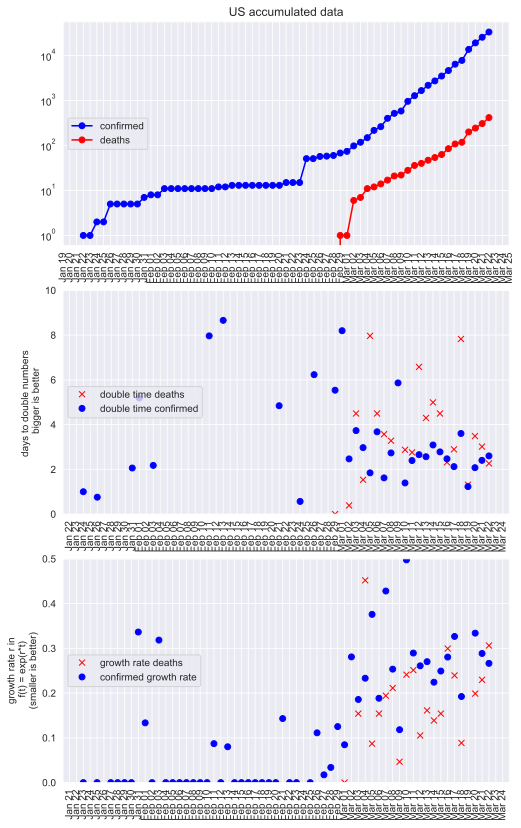

In [161]:
overview_plot(c2);

In [ ]:
# compute doubling time (and growth rate) for a longer sequence of days (by fitting)


reduced chi^2: 0.2158372632548668
r   : 0.144
t0  : 9.52
a0  : 4.04



------------------------------------------------------------------
| FCN = 0.2158                  |     Ncalls=148 (148 total)     |
| EDM = 7.04E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | r    |   0.14    |   0.10    |            |            |         |         |       |
| 1 | t0   |    10     |    14     |            |            |         |         |       |
| 2 | a0   |    4.0    |    3.1    |            |            |         |         |       |
------------------------------------------------------------------------------------------

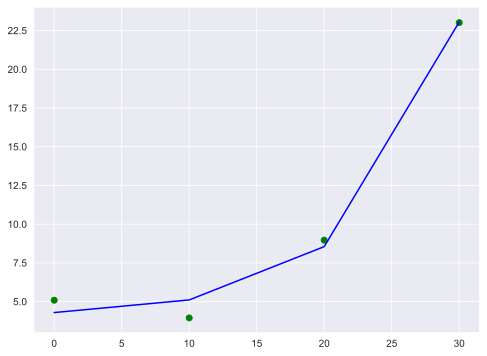

In [233]:
def pretty_params(**par):
    end='\n'
    s = ""
    for p in par:
        s += f"{p:3} : {par[p]:.3g}" + end
    return s


def model(xdata, r, t0, a0):
    return np.exp(r*(xdata-t0))+a0



def exp_fit(xdata, ydata, p0):
    r, t0, a0 = p0
    
    def least_squares(r, t0, a0):
        yvar = 10
        return sum((ydata - model(xdata, r, t0, a0))**2)/yvar
    
    m = iminuit.Minuit(least_squares, 
                       r=r, t0=t0, a0=a0, error_r=0.02, error_t0=0.2, error_a0=1, 
                       errordef=1)
    res = m.migrad()
    print(f"reduced chi^2: {m.fval / (len(ydata) - 3)}")
    r, t0, a0 = m.np_values()
    print(pretty_params(r=r, t0=t0, a0=a0))
    
    return m, res

def plot(xdata, ydata, r, t0, a0):
    #r, t0, a0 = m.np_values()

    fitted = model(xdata, r, t0, a0)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(xdata, ydata, 'og')
    ax.plot(xdata, fitted, '-b')
    #ax.legend(["data", "fit: $n(t) = c(t-t_0)^p+a_0$"])
    #ax.set_title(f"Infections $n(t)$ ({pretty_params(param_infections, end=', ')})")
    #ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    #ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))
    #ax.tick_params(axis='x', rotation=90)
    #fig.savefig('figures/infections-with-model-fit.svg')
    # print(fitted_infections)

def test_model(): 
    xdata = np.linspace(0, 30, 4)
    ydata = 0 + np.exp(0.1*(xdata - 0)) + 5*np.random.random_sample(xdata.shape)    
    m, res = exp_fit(xdata, ydata, (.1, 0.00, 0.0))
    r, t0, a0 = m.np_values()
    plot(xdata, ydata, r, t0, a0)
    return res, m, xdata, ydata


res, m, xdata, ydata = test_model()
res


In [258]:
def grow_rate_n_days(series, n=5):
    """Use the last 4 data points to estimate growth rate (and doubling time) for each day"""
    par = pd.DataFrame(index=series.index, columns=['r', 't0', 'a0', 'chi2'])
    print(f"Data stack shape = {series.shape}")
    for i in range(n, len(series)):
        start = i-n
        end = i
        print(f"Working on {start} to {end}, this is {start}/{len(series-n)}")
        xdata_0 = (series.index[start:end] - series.index[0])
        xdata = np.array((xdata_0.astype("timedelta64[D]").astype(float)))
        ydata = series.values[start:end]
        # Attempt fit
        m, res = exp_fit(xdata, ydata, (.1, 0.00, 0.0))
        r, t0, a0 = m.np_values()
        par.iloc[i].at['r'] = r
        par.iloc[i].at['t0'] = t0
        par.iloc[i].at['a0'] = a0
        print(f"r={r:10}, t0={t0:10}, a0={a0:10}")
        plot(xdata, ydata, r, t0, a0)
            
    return par

Data stack shape = (63,)
Working on 0 to 5, this is 0/63
reduced chi^2: 6.571466319281603e-07
r   : 0.001
t0  : 2.95
a0  : -1

r=0.0010034700782384017, t0=2.9464835463896226, a0=-0.9998381372990248
Working on 1 to 6, this is 1/63
reduced chi^2: 8.522763306492919e-05
r   : 3.07
t0  : 4.99
a0  : -0.011

r=3.065152169779282, t0=4.99402203548301, a0=-0.011049239560382772
Working on 2 to 7, this is 2/63
reduced chi^2: 0.001980084883077143
r   : 1.35
t0  : 4.95
a0  : -0.103

r=1.349214991307077, t0=4.953524419847204, a0=-0.10254749134356436
Working on 3 to 8, this is 3/63
reduced chi^2: 0.11016760288312819
r   : 0.204
t0  : -3.56
a0  : -4.18

r=0.2039430471515358, t0=-3.5573205135912227, a0=-4.181860257188619
Working on 4 to 9, this is 4/63
reduced chi^2: 0.16880760234326747
r   : 0.0483
t0  : -58.5
a0  : -20

r=0.048297329331434935, t0=-58.454700530035616, a0=-19.95009729962182
Working on 5 to 10, this is 5/63
reduced chi^2: 0.14937454308403858
r   : 0.0577
t0  : -38.2
a0  : -10.1

r=0.0577

/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Working on 22 to 27, this is 22/63
reduced chi^2: 1.5577511493764102e-05
r   : 0.00439
t0  : -9.7
a0  : 14.8

r=0.004389901182577018, t0=-9.696682024954603, a0=14.843791527145296
Working on 23 to 28, this is 23/63
reduced chi^2: 8.35495570655027e-05
r   : 0.00998
t0  : 5.39
a0  : 14.8

r=0.009976919216042025, t0=5.385734953485115, a0=14.79003112988072
Working on 24 to 29, this is 24/63
reduced chi^2: 4.3573374781984143e-07
r   : 0.000854
t0  : 6.95
a0  : 15

r=0.0008542977036544062, t0=6.947236769077016, a0=14.984074091934211
Working on 25 to 30, this is 25/63
reduced chi^2: 1.618647429066488e-06
r   : 0.00171
t0  : 11.1
a0  : 15

r=0.0017125638875575095, t0=11.050998990988143, a0=14.971778216861066
Working on 26 to 31, this is 26/63
reduced chi^2: 1.8449004464260076e-07
r   : 0.0006
t0  : 8.81
a0  : 15

r=0.0006004251278779262, t0=8.805700545859692, a0=14.98839696259139
Working on 27 to 32, this is 27/63
reduced chi^2: 0.00014750486679361032
r   : 0.0138
t0  : 13.2
a0  : 14.8

r=0.013

/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.



r   : 0.0571
t0  : 9.05
a0  : 12.5

r=0.057050491186823905, t0=9.05285482922507, a0=12.483244404082397
Working on 31 to 36, this is 31/63
reduced chi^2: 0.0003253804537634937
r   : 2.36
t0  : 34
a0  : 16

r=2.356819708631718, t0=33.98208075289294, a0=15.970846313229
Working on 32 to 37, this is 32/63
reduced chi^2: 0.23603456990270683
r   : 1.03
t0  : 32.6
a0  : 14.6

r=1.0255648895538438, t0=32.63413102349883, a0=14.612774248816452
Working on 33 to 38, this is 33/63
reduced chi^2: 3.9690855060072785
r   : 0.123
t0  : 0.071
a0  : -45.1

r=0.1234970085539178, t0=0.07103321660695683, a0=-45.06308572692733
Working on 34 to 39, this is 34/63
reduced chi^2: 5.274572318849627
r   : 0.297
t0  : 23.1
a0  : -7.12

r=0.29705167039182684, t0=23.087667224555563, a0=-7.123259738554241
Working on 35 to 40, this is 35/63
reduced chi^2: 4.665660430946717
r   : 0.654
t0  : 31.9
a0  : 23.3

r=0.6536700504091099, t0=31.85782118715192, a0=23.281546505409906
Working on 36 to 41, this is 36/63
reduced chi^

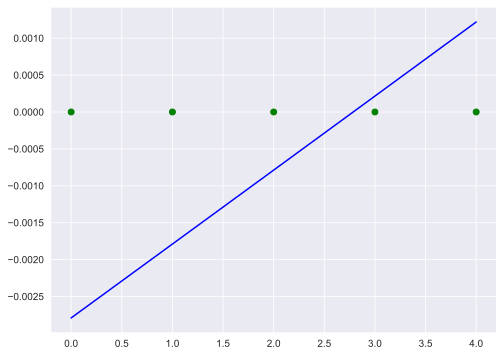

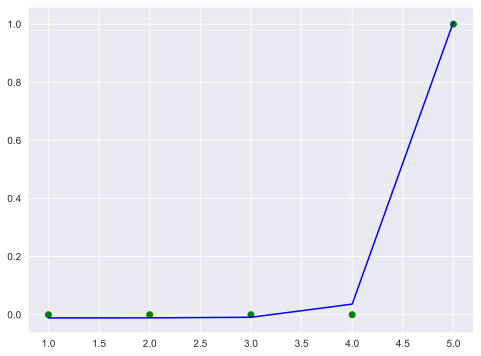

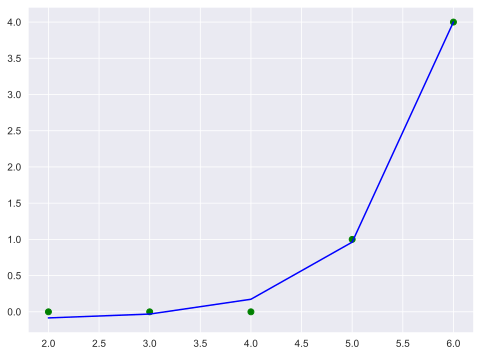

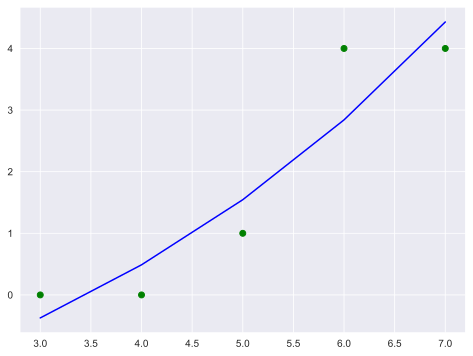

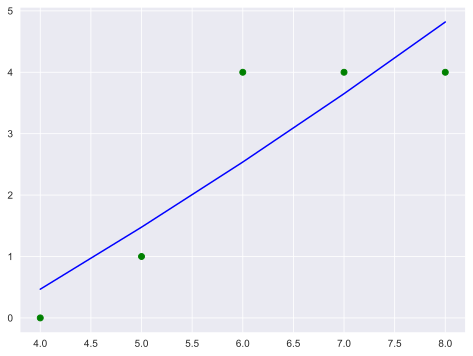

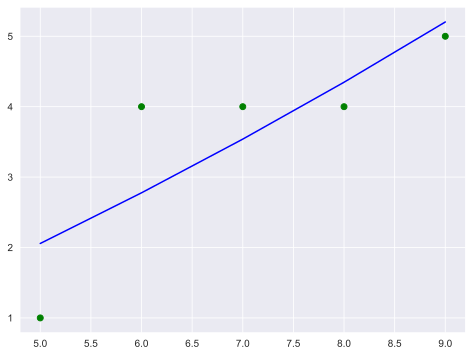

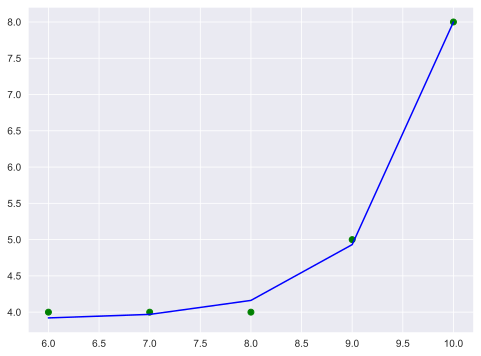

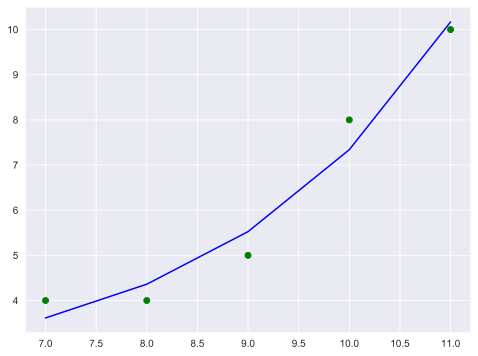

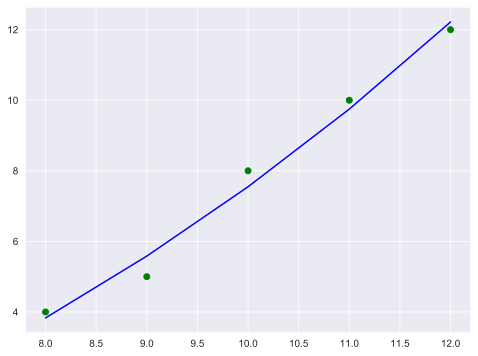

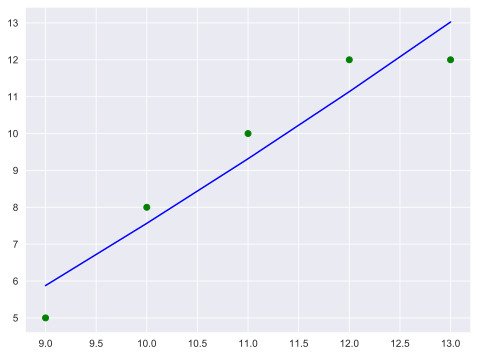

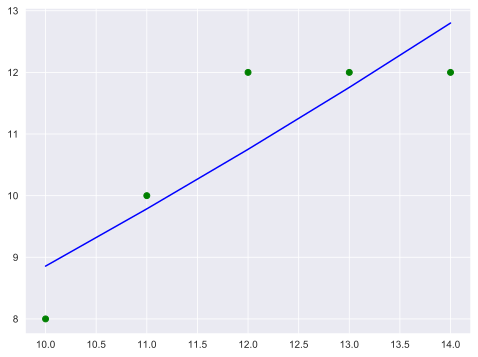

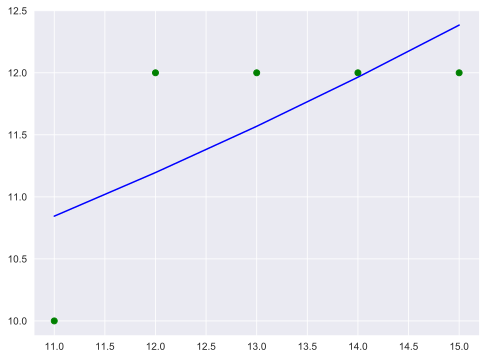

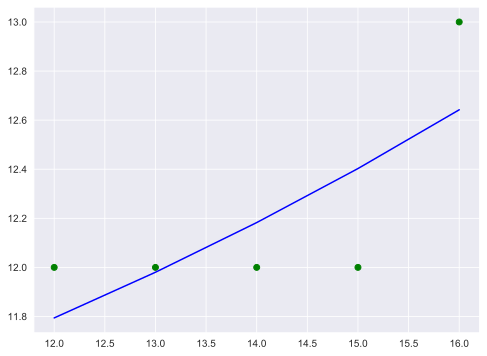

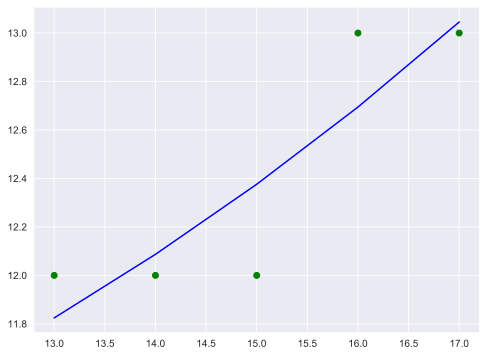

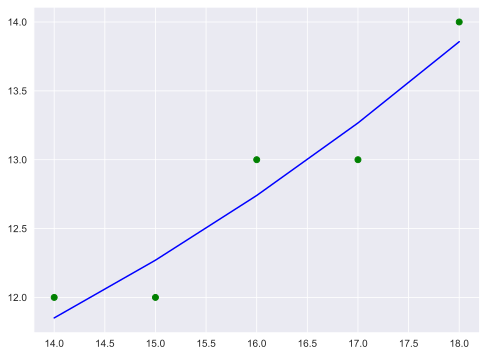

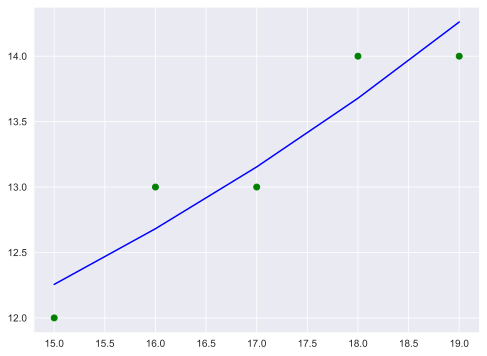

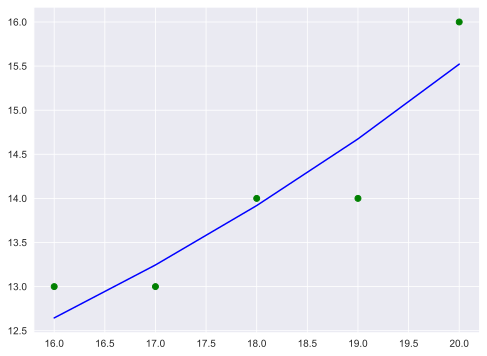

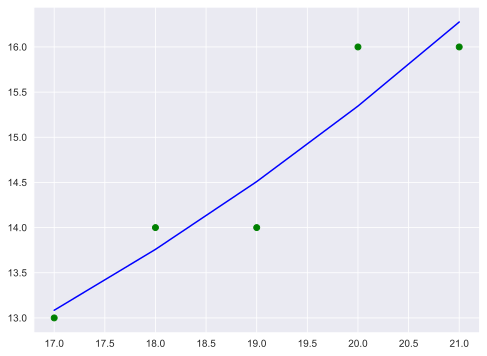

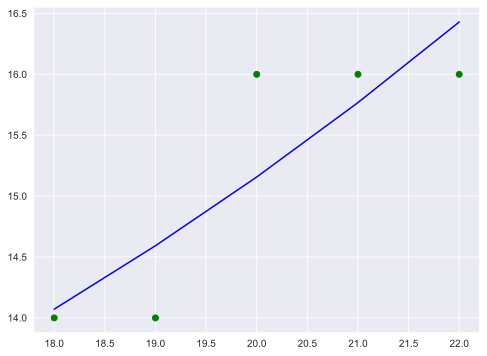

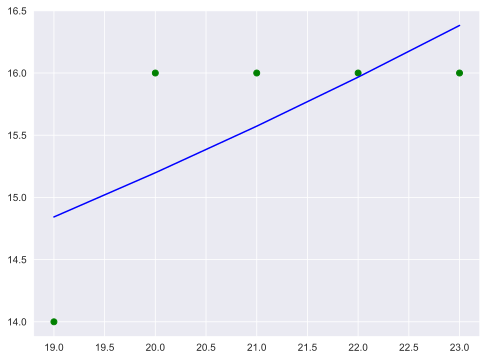

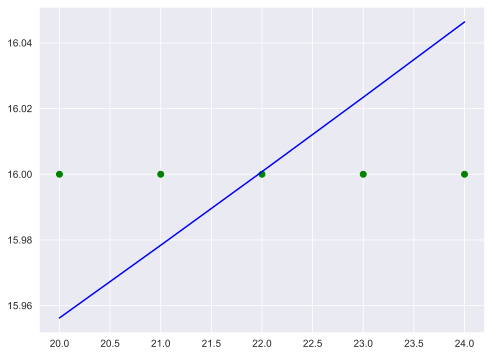

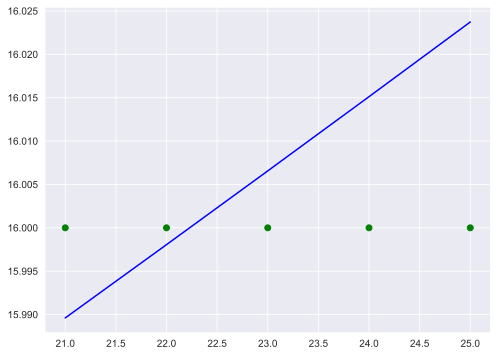

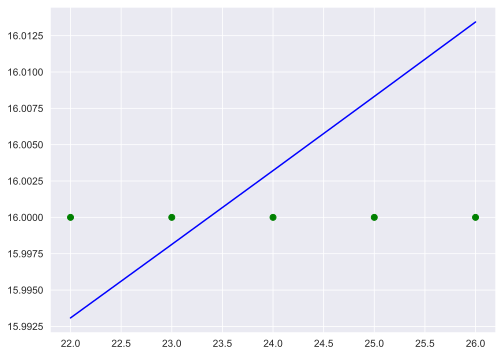

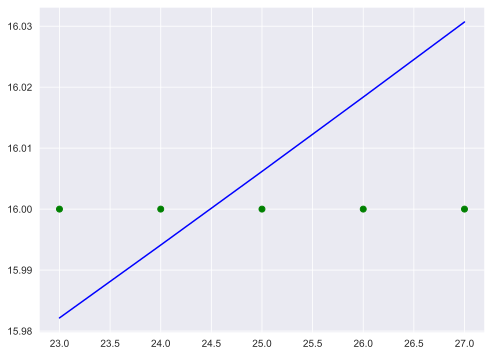

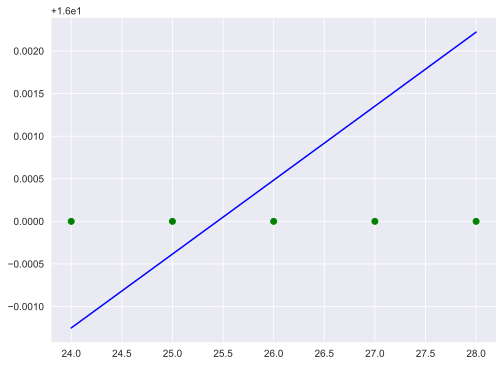

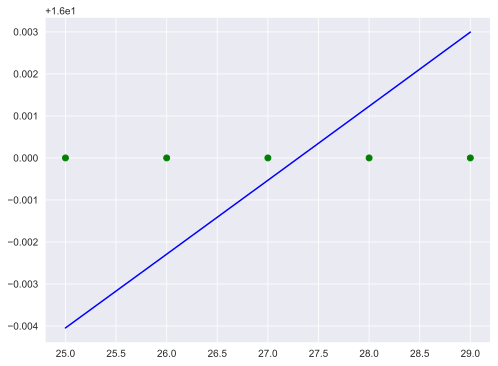

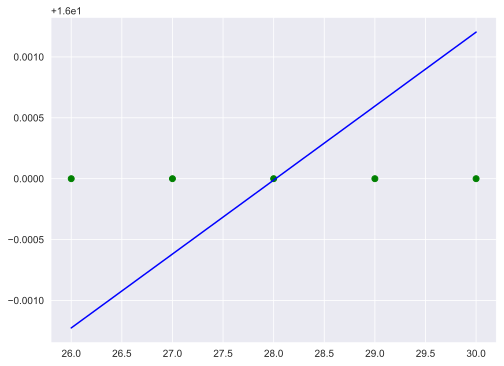

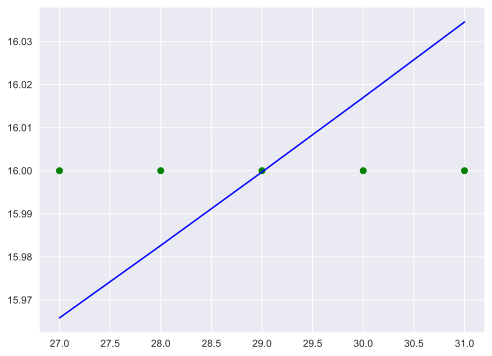

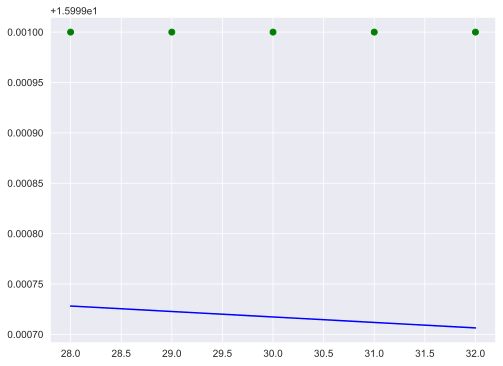

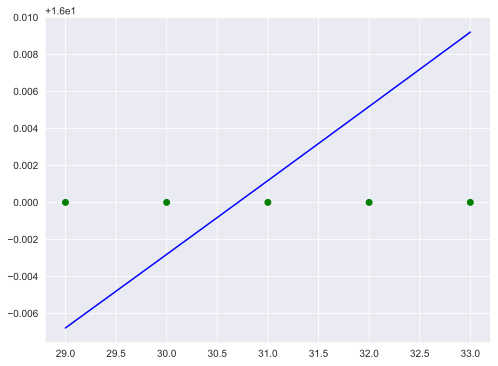

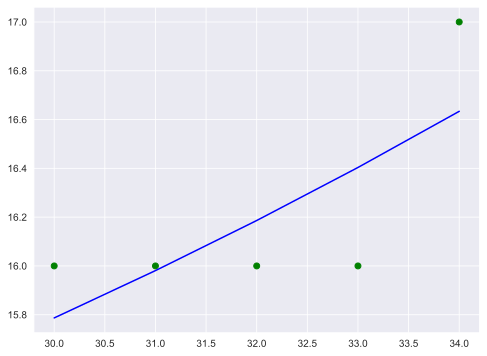

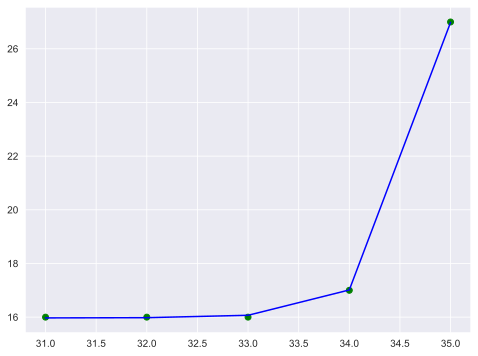

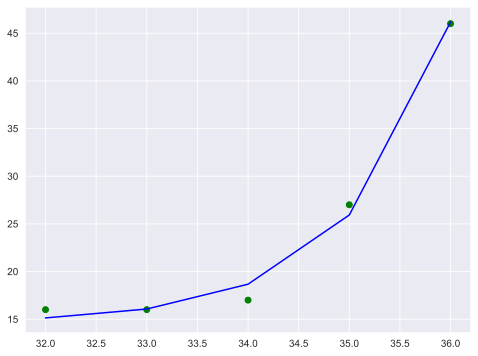

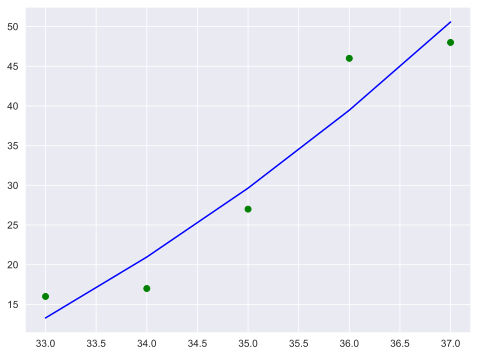

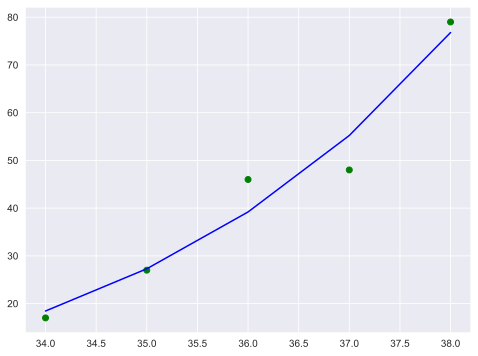

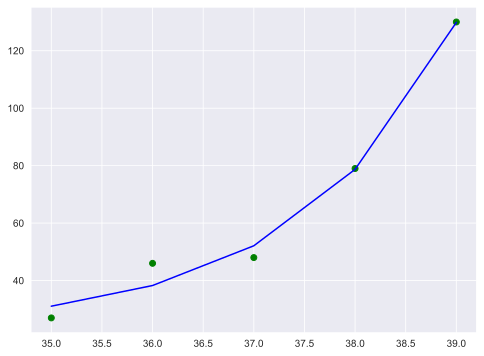

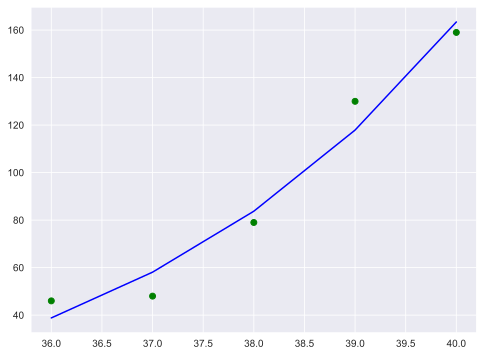

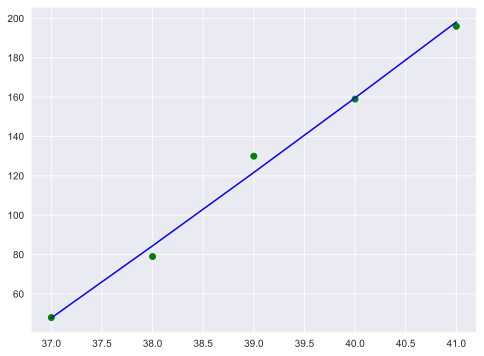

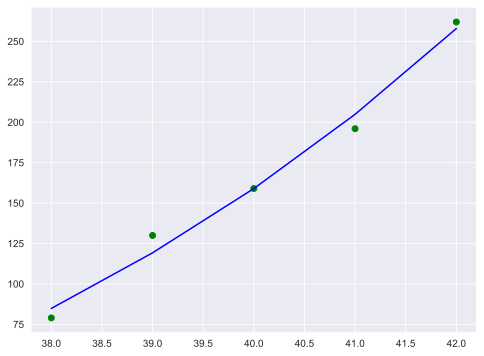

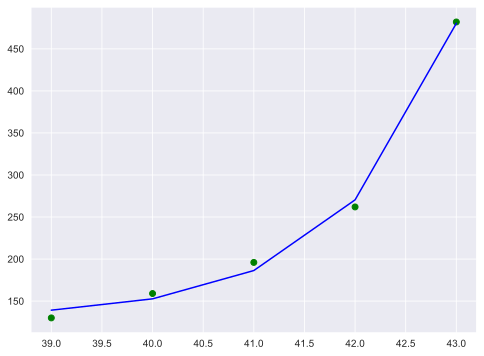

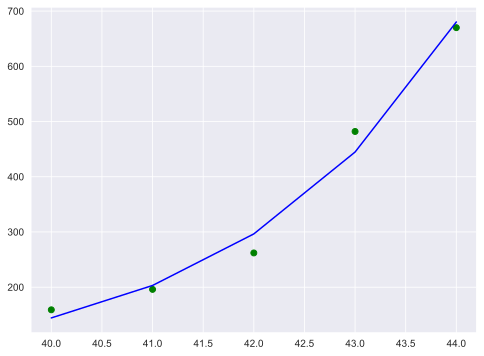

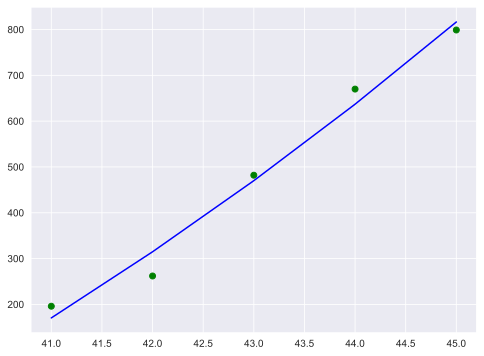

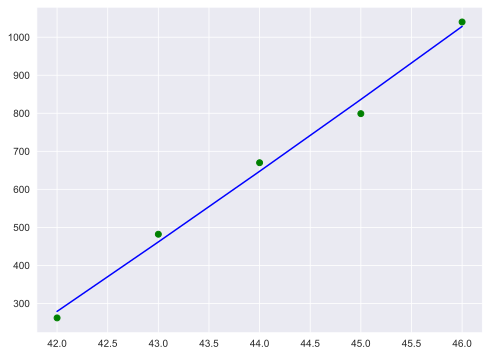

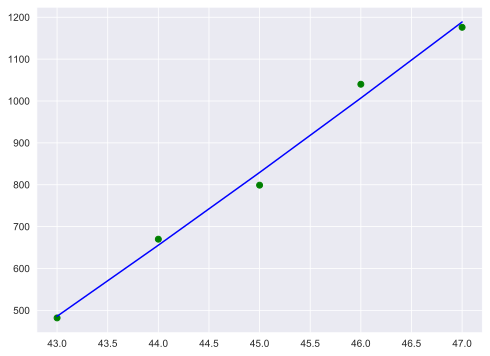

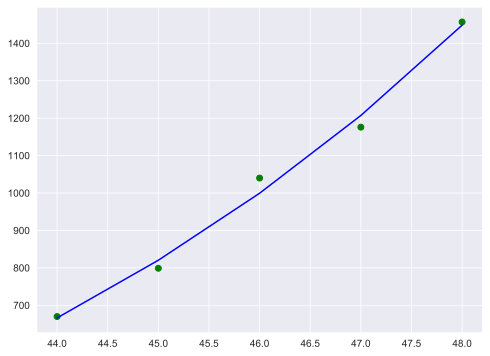

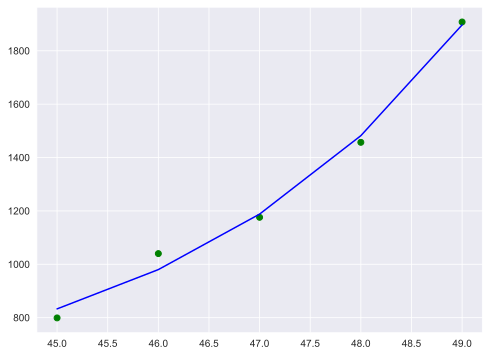

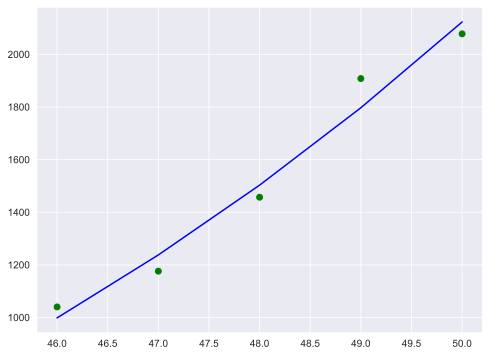

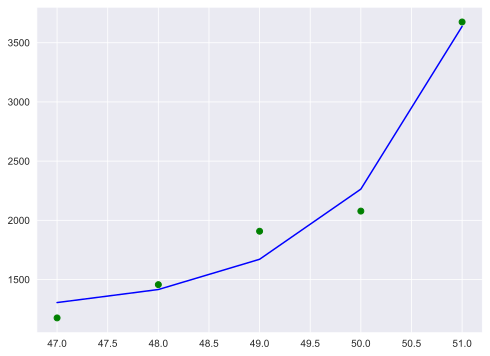

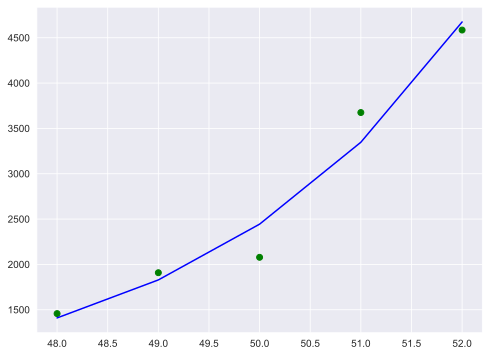

In [ ]:
    
c = stack_country('Germany')
p = grow_rate_n_days(c['confirmed'])
#

In [257]:
p.tail(n=10)

,r,t0,a0,chi2
2020-03-15,0.315573,25.1758,-81.7752,NaN
2020-03-16,0.0210549,-468.798,-53214.4,NaN
2020-03-17,0.236006,16.4198,166.675,NaN
2020-03-18,0.25463,19.3666,532.069,NaN
2020-03-19,0.381141,31.9567,2771.83,NaN
2020-03-20,0.177773,1.35496,-4403.22,NaN
2020-03-21,0.220287,12.6939,-1806.92,NaN
2020-03-22,0.024674,-422.298,-121118,NaN
2020-03-23,0.0191803,-566.695,-140845,NaN
2020-03-24,0.313978,30.3883,14088.4,NaN


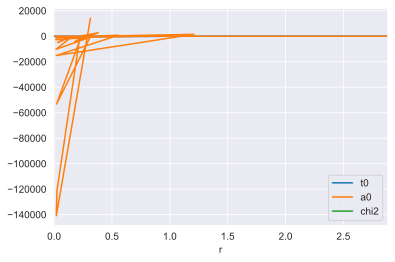

In [256]:
p.plot('r')

In [215]:
p.at['r', 3] = 10

Log basics ...

In [ ]:
from math import log 
log(2)/log(0.5)

From https://en.wikipedia.org/wiki/Doubling_time
    
$$\Delta t = (t_2 - t_1) * \left(\frac{\log(2)}{\log
    \left(\frac{f(t_2)}{f(t_1)}\right)}\right)$$

In [ ]:
from math import log
def double_time_exponential(t1, t2, q1, q2):
    return (t2 - t1) * (log(2) / log(q2/q1) )

def growth_rate(double_time):
    return log(2)/double_time


t1, t2, q1, q2 = 0, 1, 1, 2
double_time_exponential(t1, t2, q1, q2), growth_rate(double_time_exponential(t1, t2, q1, q2) )

In [ ]:
2**(1/double_time_exponential(0, 1, 1, 21))

In [ ]:
2/math.exp(1)

In [ ]:
math.exp(0.5)/2

In [ ]:
math.exp(0.6931471805599453*4)